In [1]:
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression

from lib.creditcard_fraud_dataset import get_train_test_dfs, X_COLS
from lib.cs_eval import evaluate_pred

# 4. Cost-sensitive threshold

Instead of modifying the training procedure to make it cost-sensitive, we can also make the test-time procedure cost-sensitive. More specifically, we can **modify the threshold** for a prediction to be classified as positive.

We will classify a positive class probability $P_{+}$ as positive if and only if

$$
P_{+} > \frac{C_{FP}}{C_{FP} + C_{FN}}
$$

As you can see, the higher the false negative cost, the *easier* we will classify a sample as positive.

## 4.1 Train

For this cost-sensitive method, we only need to train a *single classifier*.

In [2]:
df_train, df_test = get_train_test_dfs()

X_train = df_train[X_COLS]
y_train = df_train['Class']

clf = LogisticRegression(max_iter=500)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=500)

## 4.2 Evaluate

### 4.2.1 Obtaining probability estimates

To apply the cost-sensitive threhold, we need to manually set our decision threshold. We can use the output of [`predict_proba()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba) for this. That method returns the *probability estimate of each class*, instead of the classification result itself.

In [3]:
X_test = df_test[X_COLS]
y_test = df_test['Class']

# Get probability estimates
y_proba = clf.predict_proba(X_test)

In [4]:
y_proba

array([[1.81823471e-08, 9.99999982e-01],
       [9.99898645e-01, 1.01354967e-04],
       [9.99953980e-01, 4.60197335e-05],
       ...,
       [9.99575336e-01, 4.24663517e-04],
       [9.99863230e-01, 1.36769760e-04],
       [9.99999908e-01, 9.16497049e-08]])

As you can see above, `y_proba` is a numpy array with *two columns*: one column for each class. We threshold on the probability of being fraudulent, so we are only interested in column `1` (rightmost column). We can select that column as follows:

In [5]:
y_proba[:, 1]

array([9.99999982e-01, 1.01354967e-04, 4.60197335e-05, ...,
       4.24663517e-04, 1.36769760e-04, 9.16497049e-08])

### 4.2.2 Apply thresholds

Now, we will use two thresholds: the regular threshold of $0.5$ and the cost-sensitive threshold.

In [6]:
# Classification with regular threshold of 0.5
y_pred_no_cs = y_proba[:, 1] > 0.5

# Classification with cost-sensitive threshold
cs_thresh = df_test['C_FP'] / (df_test['C_FP'] + df_test['C_FN'])
y_pred_cs = y_proba[:, 1] > cs_thresh

### 4.2.3 Compute evaluation metrics and visualize

In [7]:
# Get the transaction amounts
amounts = df_test['Amount']

# Compute metrics for each classifier
eval_metrics_no_cs = evaluate_pred(y_test, y_pred_no_cs, amounts)
eval_metrics_cs    = evaluate_pred(y_test, y_pred_cs,    amounts)

In [8]:
df = pd.DataFrame([
    {
        'Method': 'Regular threshold (0.5)',
        **eval_metrics_no_cs
    },
    {
        'Method': 'Cost-sensitive threshold',
        **eval_metrics_cs
    },
])

In [9]:
df

,Method,Cost Precision,Cost Recall,TP Amount,FP Amount,FN Amount,Net Recovered Amount
0,Regular threshold (0.5),0.997766,0.514306,16075.45,36.0,15181.12,858.33
1,Cost-sensitive threshold,0.972386,0.858473,26832.93,762.0,4423.64,21647.29


<AxesSubplot:xlabel='Method', ylabel='Cost Recall'>

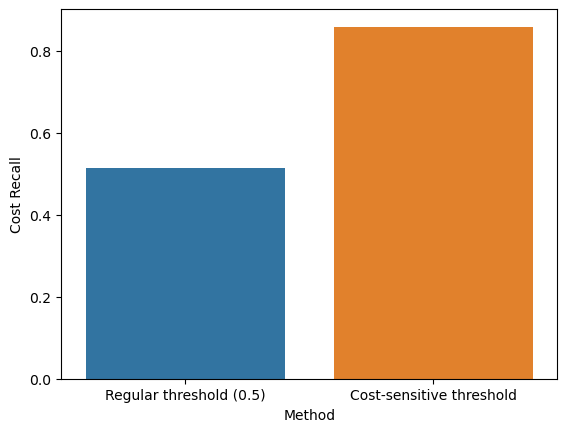

In [10]:
sns.barplot(data=df, x='Method', y='Cost Recall')

<AxesSubplot:xlabel='Method', ylabel='Cost Precision'>

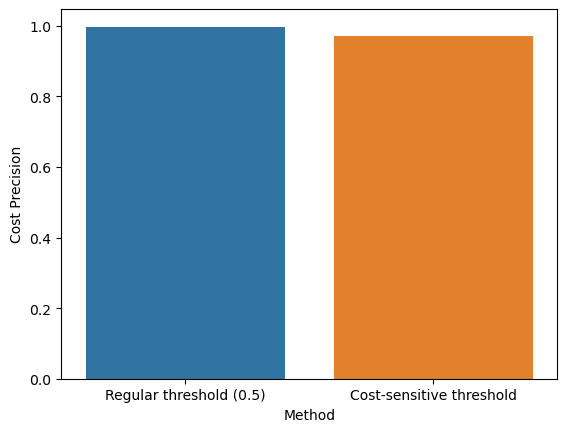

In [11]:
sns.barplot(data=df, x='Method', y='Cost Precision')